# Instagram Performance Insights: Engagement & Reach
> *This project examines Instagram post performance for Tokyo Student Mobilization, with a focus on reach and engagement. By analyzing post-level metrics alongside engineered features—such as posting time, media type, caption length, and hashtag usage—we aim to uncover patterns and relationships that drive audience interaction. Using trend analysis, distribution plots, and correlation studies, this analysis investigates how different posting strategies impact both content exposure and follower engagement.*
>
> **Key Questions**
> - How do reach and engagement evolve over time?
> - How do posting features—like media type and caption length—relate to engagement and reach?
> - Which features or patterns are most strongly associated with high engagement or high reach posts?
>- Do temporal patterns, such as the time of day or day of the week a post is published, influence overall reach or engagement trends?

In [ ]:
#Install the 'ipython-sql' and 'prettytable' libraries using pip
!pip install ipython-sql prettytable

# Import necessary Python modules for API calls, JSON handling, SQLite, datetime, and data analysis
import requests, json, sqlite3, sys
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import prettytable 
prettytable.DEFAULT = 'DEFAULT'

# Load SQL magic extension to run SQL queries directly in notebook cells
%load_ext sql

## Instagram Data Collection & Preparation
> In this section, we set up a object-oriented pipeline to **collect raw post data and insights from the Instagram Graph API**, store them in a local SQLite database, and then **transform the JSON responses into a structured dataset** for analysis.

### Data Collection Class: `InstaCollector`
> 
>This class manages all **data ingestion** tasks, including:
>- Initializing API connection parameters and SQLite database
>- Creating local SQLite tables to store raw JSON post and account data
>- Fetching post fields and handling pagination to store data locally
>- Fetching detailed post insights (metrics) and updating the local database
>- Closing the database connection upon completion

In [85]:
# Define InstaCollector class to:
# - Initialize connection details for Instagram Graph API
# - Connect and create SQLite tables
# - Fetch post fields and store raw JSON data
# - Fetch post insights (metrics) and update SQLite database
# - Close database connection

class InstaCollector:
    def __init__(self, ACCESS_TOKEN, IG_BUSINESS_ID, base_url, endpoints, queries):
        self.access_token = ACCESS_TOKEN
        self.ig_business_id = IG_BUSINESS_ID
        self.base_url = base_url
        self.endpoints = endpoints
        self.queries = queries

    def db_initializer(self, db):
        # Connect locally to SQLite database 
        self.db = db
        self.conn = sqlite3.connect(self.db)
        self.cursor = self.conn.cursor()
    
    def db_tables(self):
        # Create tables for storing post JSON and account info
        self.cursor.executescript('''
        	DROP TABLE IF EXISTS kgc_json;
    		DROP TABLE IF EXISTS kgc_account;

    		CREATE TABLE IF NOT EXISTS kgc_json (
    		post_id INTEGER NOT NULL PRIMARY KEY UNIQUE,
    		fields_json TEXT, -- post fields 
    		insights_json TEXT ); -- feed/reels insights 

    		CREATE TABLE IF NOT EXISTS kgc_account (
    		id INTEGER NOT NULL PRIMARY KEY UNIQUE, -- autoincremented index 
    		followers_count INTEGER,
    		media_count INTEGER,
    		follows_count INTEGER,
    		date_collected DATETIME UNIQUE ) -- logic key
    		''')
        self.conn.commit()

    def get_fields(self):
        # Fetch post fields using Instagram API, handle pagination,
        # and store raw JSON in SQLite kgc_json table
        self.post_ids = list()
        while True: # execute the while loop for the sake of pagination (there are many pages of data returned by the API call)
            try: # the page url will change with each pagination
                fields_response = requests.get(next_page, params = self.queries['post_fields']) # this will only work after the first page
            except:
                fields_url = base_url + self.endpoints['instagram_business_id'] + '/' + self.endpoints['media'] # this will only work on the first page
                fields_response = requests.get(fields_url, params = self.queries['post_fields'])
            try:
                fields_data = json.loads(fields_response.text)['data'] # extracting raw data from the json formatted string 
            except: 
                print('access token has expired!')
                sys.exit()
            self.post_ids.extend(post['id'] for post in fields_data) # append post ids for this page 

            for post in fields_data:
                self.cursor.execute('''INSERT OR IGNORE INTO kgc_json (post_id, fields_json) VALUES (?, ?)''', (int(post['id']), json.dumps(post))) #loads raw json data into SQL table 
                self.conn.commit()
	        	# the reason why we have to call the json.dumps(post) method is because post is a dictionary and we want to dump it into a json formatted string 
	        		# for storing in SQL, which we will later convert back into a python dict by using json.loads(post) when we parse the data
	      
            if 'paging' in fields_response.json() and 'next' in fields_response.json()['paging']: #this is where we check for the existence of a 'next' page
                next_page = fields_response.json()['paging']['next'] # the url for next page is stored at the end of the response 
            else: break # once all pages have been combed we break the while loop and return all of the data

        # Fetch and store account-level fields
        account_url = self.base_url + '/' + self.endpoints['instagram_business_id']
        account_response = requests.get(account_url, params = self.queries['account_fields'])
        account_data = json.loads(account_response.text)
	    
        self.cursor.execute('''INSERT OR IGNORE INTO kgc_account (followers_count, media_count, follows_count, date_collected) VALUES (?, ?, ?, ?)''', 
			(int(account_data['followers_count']), int(account_data['media_count']), int(account_data['follows_count']), str(datetime.now())))
        self.conn.commit()
 
    def get_insights(self):
        # Retrieve all posts from SQLite and fetch insights (metrics) from Instagram API
        self.cursor.execute('''SELECT fields_json FROM kgc_json''')
        posts = self.cursor.fetchall() #returns a list

        # Iterate through all posts and their respective JSON strings 
        for post in posts:
            post = json.loads(post[0]) # each post is a single valued tuple containing json formatted string
            insights_url = self.base_url + post['id'] + '/' + self.endpoints['insights'] # the base url will be the same for both feed and reels 
            if post['media_type'] == 'VIDEO':
                insights_queries = self.queries['reels_insights'] # establish API queries specific to reels 
            else: 
                insights_queries = self.queries['feed_insights'] # establish API queries specific to feed (non-reels)
		  
            insights_response = requests.get(insights_url, params = insights_queries) 
            insights_data = insights_response.text # no need to use json.loads() method because we will parse through the json string later 
            if 'error' in insights_data: continue # many of the posts were made before the account was converted to creator type so they will not return any insights
            
            self.cursor.execute('''UPDATE kgc_json SET insights_json = ? WHERE post_id = ?''', (insights_data, post['id']))
            self.conn.commit()
    
    def db_closer(self):
        # Close the database connection 
        self.conn.close()

### Data Loading Class: `InstaLoader`
>
>This class manages **data transformation and loading** tasks, including:
>- Retrieving stored JSON data from SQLite
>- Converting JSON strings into Python dictionaries
>- Flattening insights JSON into a structured pandas DataFrame
>- Loading the cleaned dataset back into SQLite as a table

In [7]:
# Define InstaLoader class to:
# - Load raw JSON fields and insights from SQLite
# - Convert JSON strings to Python dictionaries
# - Flatten insights JSON into structured DataFrame and save back to SQLite

class InstaLoader:
    def __init__(self, db):
        self.db = db
        self.conn = sqlite3.connect(self.db)
        self.cursor = self.conn.cursor()

    def fields_loader(self):
        # Load posts' fields_json where insights exist, convert JSON strings to dicts
        self.cursor.execute('''
            SELECT fields_json FROM kgc_json WHERE insights_json NOT NULL''')
		# cursor.fetchall() returns a list of single-valued tuples
  			# so we take the 0th value of each tuple in the list and convert it to a python dictionary 
        self.fields_dicts = [json.loads(post[0]) for post in self.cursor.fetchall()] # a list of dictionaries 

    def insights_loader(self):
        # Define metrics to extract depending on media type
        insights_metrics = {
            'feed' : ['reach','saved','shares','total_interactions','follows','profile_visits','profile_activity','views'],
            'reels' : ['reach','saved','shares','total_interactions','views','ig_reels_video_view_total_time','ig_reels_avg_watch_time']
        }

        # Load insights_json where available and convert to dicts
        self.cursor.execute('''SELECT insights_json FROM kgc_json WHERE insights_json NOT NULL''')
		# cursor.fetchall() returns a list of single-valued tuples
  			# so we take the 0th value of each tuple in the list and convert it to a python dictionary 
        insights_raw = [json.loads(post[0]) for post in self.cursor.fetchall()] 
        self.insights_dicts = list()

        # Map metrics to each post based on media type
        for p in range(len(insights_raw)):
            post_dict = {'id' : self.fields_dicts[p]['id']}
            if self.fields_dicts[p]['media_type'] == 'VIDEO': metrics = insights_metrics['reels']
            else: metrics = insights_metrics['feed']
            for m in range(len(metrics)):
                post_dict[metrics[m]] = insights_raw[p]['data'][m]['values'][0]['value']
            self.insights_dicts.append(post_dict)

        # Convert to pandas DataFrame and save as SQL table 'insights'
        insights_df = pd.DataFrame(self.insights_dicts)
        insights_df.to_sql(name = 'insights', con = conn, if_exists = 'replace', index = False)
        print("Successfully loaded insights table to SQLite!")
    
    def db_closer(self):
        # Close the database connection 
        self.conn.close()

### API Credentials & Queries
>
>API credentials are securely stored in a local graph_api.txt file (not uploaded to GitHub).
The following queries are defined for use with the Graph API:
>- **Post fields**: post metadata (caption, timestamp, likes, comments, etc.)
>- **Feed insights**: reach, saves, shares, total interactions, follows, profile activity, views
>- **Reels insights**: reach, saves, shares, total interactions, views, average watch time, total watch time
>- **Account fields**: follower count, media count, follows count

In [8]:
# Load API credentials from local JSON file
with open('graph_api.txt', 'r') as file:
	info = json.loads(file.read())
	ACCESS_TOKEN = info['ACCESS_TOKEN']
	IG_BUSINESS_ID = info['IG_BUSINESS_ID']
	APP_ID = info['APP_ID']
	APP_SECRET = info['APP_SECRET']

# Define API queries for posts, insights, and account data
insta_queries = {
  'post_fields' : {
 	'access_token': ACCESS_TOKEN, # the access token must be used as a field for all API calls
    'fields' : 'id,media_type,media_url,username,comments_count,like_count,timestamp,caption,comments',
  },
  'feed_insights' : {
    'access_token': ACCESS_TOKEN,
    'metric' : 'reach,saved,shares,total_interactions,follows,profile_visits,profile_activity,views'
  },
  'reels_insights' : {
    'access_token': ACCESS_TOKEN,
    'metric' : 'reach,saved,shares,total_interactions,views,ig_reels_video_view_total_time,ig_reels_avg_watch_time'
  },
  'account_fields' : {
    'access_token' : ACCESS_TOKEN,
    'fields' : 'followers_count,media_count,follows_count'
  }
}

# Base URL and endpoints for API calls
base_url = "https://graph.facebook.com/v22.0/" # used for all API calls
endpoints = {
    'instagram_business_id': IG_BUSINESS_ID,
    'media': 'media',
    'insights': 'insights'
}

### Initialize Collector & Gather Data
>Set up the database, fetch post data and insights, and store them in SQLite.

In [ ]:
# Initialize the Instagram data collector and database
insta_collect = InstaCollector(ACCESS_TOKEN, IG_BUSINESS_ID, base_url, endpoints, insta_queries)
insta_collect.db_initializer(db='ig_data2.db')

# Uncomment if you want to reset tables (run only once or when resetting)
# insta_collect.db_tables()

# Collect posts data
insta_collect.get_fields()

# Collect post insights (metrics)
insta_collect.get_insights()

# Close DB connection
insta_collect.db_closer()

### Transform & Save Insights
>Parse and flatten raw JSON into a clean DataFrame, then save to SQLite.

In [ ]:
# Initialize data loader to transform raw JSON into structured data
insta_load = InstaLoader('ig_data2.db')

# Load posts fields from SQLite JSON to Python dicts
insta_load.fields_loader()

# Load insights JSON, flatten, and save to SQLite table 'insights'
insta_load.insights_loader()

# Close the DB connection
insta_load.db_closer()

## Extracting & Engineering Instagram Post Metrics
> - Connect to SQLite database
> - Connect to the local database `ig_data2.db` containing Instagram post JSON and insights data.
> - Initialize SQL Magic (`%sql`) to run queries directly from the notebook.

In [2]:
# Connect to the local SQLite database containing Instagram insights and post JSON data
db = 'ig_data2.db'
conn = sqlite3.connect(db)
cursor = conn.cursor()

# Initialize SQL Magic with database connection
%sql sqlite:///ig_data2.db

### Create SQL View
> **Step 1: Extract core post-level fields from JSON**
> - `media_type`: Type of post (image, video, reel)
> - `like_count`, `comments_count`: Engagement metrics
> - `timestamp`: Post timestamp (formatted)
> - `caption_length`: Number of characters in caption
> - `num_hashtags`: Number of hashtags in caption
>
> **Step 2: Join post fields with engagement and reach metrics**
> - Merge `posts` with `insights` table to include `reach`, `saved`, `shares`, `profile_activity`, etc.
>
> **Step 3: Add temporal features**
> - `days_since_last_post`: Gap since previous post
> - `days_since_first_post`: Gap since first post
> - `day_of_week` and `time_of_day`: Categorical time features for posting patterns
> 
> **Step 4: Compute engagement-related metrics**
> - `engagement`: Total likes + comments
> - `engagement_per_reach_pct`: Engagement relative to reach
> - `rolling_avg_engagement_3posts`: Rolling average engagement over last 3 posts
> - `engagement_rank_by_media_type`: Rank posts by engagement within each media type
> 
> **Step 5: Combine all features**
> - Join post-level fields, temporal features, and engagement metrics into a single SQL view
> - Order by most recent posts (`timestamp DESC`)

In [ ]:
%%sql 

-- Remove the view if it already exists
DROP VIEW IF EXISTS ig_post_metrics;

-- Create a view aggregating Instagram post data with engineered features
CREATE VIEW ig_post_metrics AS

-- Step 1: Extract core post-level fields from JSON
WITH posts AS (
    SELECT 
        post_id,
        json_extract(fields_json, '$.media_type') AS media_type, -- Type of post (e.g., image, video, reel)
        json_extract(fields_json, '$.like_count') AS like_count, -- Number of likes
        json_extract(fields_json, '$.comments_count') AS comments_count, -- Number of comments
        REPLACE(SUBSTR(json_extract(fields_json, '$.timestamp'), 1, 19), 'T', ' ') AS timestamp, -- Post timestamp (formatted)
        LENGTH(json_extract(fields_json, '$.caption')) AS caption_length, -- Total characters in caption
        LENGTH(json_extract(fields_json, '$.caption')) - LENGTH(
            REPLACE(json_extract(fields_json, '$.caption'), '#', '')) AS num_hashtags -- Count of hashtags
    FROM kgc_json
),

-- Step 2: Join post fields with engagement and reach metrics
posts_with_insights AS (
    SELECT
        p.*,
        i.reach, i.saved, i.shares, i.total_interactions,
        i.follows, i.profile_visits, i.profile_activity,
        i.views, i.ig_reels_avg_watch_time,
        i.ig_reels_video_view_total_time
    FROM 
        posts p
    LEFT JOIN 
        insights i ON i.id = p.post_id
),

-- Step 3: Add temporal features (posting patterns)
post_time_features AS (
    SELECT 
        post_id, 
        JULIANDAY(timestamp) - LAG(JULIANDAY(timestamp)) 
            OVER (ORDER BY timestamp) AS days_since_last_post, -- Gap since previous post
        JULIANDAY(timestamp) - JULIANDAY(FIRST_VALUE(timestamp)
            OVER(ORDER BY timestamp ASC)) AS days_since_first_post, -- Gap since first post in dataset        
        CASE 
            WHEN STRFTIME('%w', timestamp) = '0' THEN 'Sunday'
            WHEN STRFTIME('%w', timestamp) = '1' THEN 'Monday'
            WHEN STRFTIME('%w', timestamp) = '2' THEN 'Tuesday'
            WHEN STRFTIME('%w', timestamp) = '3' THEN 'Wednesday'
            WHEN STRFTIME('%w', timestamp) = '4' THEN 'Thursday'
            WHEN STRFTIME('%w', timestamp) = '5' THEN 'Friday'
            ELSE 'Saturday' 
        END AS day_of_week, -- Day of week posted
        CASE 
            WHEN CAST(STRFTIME('%H', timestamp) AS INT) BETWEEN 6 AND 11 THEN 'Morning'
            WHEN CAST(STRFTIME('%H', timestamp) AS INT) BETWEEN 12 AND 16 THEN 'Afternoon'
            WHEN CAST(STRFTIME('%H', timestamp) AS INT) BETWEEN 17 AND 20 THEN 'Evening'
            ELSE 'Night'
        END AS time_of_day -- Time of day posted
    FROM
        posts_with_insights
),

-- Step 4: Compute engagement-related metrics
post_engagement_metrics AS (
    SELECT 
        post_id, 
        like_count + comments_count AS engagement, -- Total engagements
        ROUND(
            (like_count + comments_count) * 100 / NULLIF(reach, 0),
            2) AS engagement_per_reach_pct, -- Engagement as % of reach
        ROUND(
            AVG(like_count + comments_count) 
            OVER (ORDER BY timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW))
            AS rolling_avg_engagement_3posts, -- Rolling average engagement 
        RANK() 
            OVER (PARTITION BY media_type ORDER BY (like_count + comments_count) DESC) 
            AS engagement_rank_by_media_type -- Group by media type, rank by post engagement
    FROM 
        posts_with_insights
)

-- Step 5: Combine all features into final view
SELECT 
    pwi.*,
    ptf.days_since_last_post,
    ptf.days_since_first_post,
    ptf.day_of_week,
    ptf.time_of_day,
    pem.engagement,
    pem.rolling_avg_engagement_3posts,
    pem.engagement_per_reach_pct,
    pem.engagement_rank_by_media_type
FROM 
    posts_with_insights pwi
LEFT JOIN 
    post_time_features ptf ON pwi.post_id = ptf.post_id
LEFT JOIN 
    post_engagement_metrics pem ON pwi.post_id = pem.post_id
ORDER BY timestamp DESC

### Load SQL View Into DataFrame
>
>- Use `%sql` to query `ig_post_metrics` and convert results to a DataFrame (`ig_metrics_df`) for further analysis.
>- Once data is in pandas, we close the database connection.

In [ ]:
# Query the engineered SQL view into a pandas DataFrame for analysis
ig_post_metrics = %sql SELECT * FROM ig_post_metrics 
ig_metrics_df = ig_post_metrics.DataFrame()

# Close the SQLite connection (not needed once data is in DataFrame)
conn.close()

## Data Overview & Cleaning
>
>- Display the DataFrame structure, column data types, and non-null counts.
>- Generate summary statistics for both numeric and categorical columns.
>- Identify the number of missing values in each column.
>- Replace `NaN` values with 0 in selected columns (`caption_length`, `num_hashtags`, `days_since_last_post`) before analysis.

In [4]:
# Display summary of DataFrame structure, data types, and non-null counts
ig_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   post_id                         97 non-null     int64  
 1   media_type                      97 non-null     object 
 2   like_count                      97 non-null     int64  
 3   comments_count                  97 non-null     int64  
 4   timestamp                       97 non-null     object 
 5   caption_length                  89 non-null     float64
 6   num_hashtags                    89 non-null     float64
 7   reach                           35 non-null     float64
 8   saved                           35 non-null     float64
 9   shares                          35 non-null     float64
 10  total_interactions              35 non-null     float64
 11  follows                         24 non-null     float64
 12  profile_visits                  24 non

In [5]:
# Descriptive statistics for all columns (numeric & categorical)
ig_metrics_df.describe(include = 'all')

,post_id,media_type,like_count,comments_count,timestamp,caption_length,num_hashtags,reach,saved,shares,...,ig_reels_avg_watch_time,ig_reels_video_view_total_time,days_since_last_post,days_since_first_post,day_of_week,time_of_day,engagement,rolling_avg_engagement_3posts,engagement_per_reach_pct,engagement_rank_by_media_type
count,9.700000e+01,97,97.000000,97.000000,97,89.000000,89.000000,35.000000,35.000000,35.000000,...,11.000000,1.100000e+01,96.000000,97.000000,97,97,97.000000,97.000000,35.000000,97.000000
unique,NaN,3,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7,3,NaN,NaN,NaN,NaN
top,NaN,CAROUSEL_ALBUM,NaN,NaN,2025-07-03 08:03:31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Wednesday,Morning,NaN,NaN,NaN,NaN
freq,NaN,43,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25,55,NaN,NaN,NaN,NaN
mean,1.802788e+16,NaN,22.226804,0.463918,NaN,105.078652,0.067416,851.571429,1.771429,2.028571,...,7856.909091,8.956386e+06,12.189742,538.334634,NaN,NaN,22.690722,22.457732,3.000000,18.206186
std,1.332764e+14,NaN,18.365789,1.051406,NaN,128.244194,0.330212,681.669201,2.087578,2.255525,...,3751.763171,6.115310e+06,12.766512,381.005808,NaN,NaN,18.674493,12.460979,2.363945,11.488163
min,1.784304e+16,NaN,1.000000,0.000000,NaN,1.000000,0.000000,255.000000,0.000000,0.000000,...,3079.000000,1.785540e+06,0.000197,0.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000
25%,1.794300e+16,NaN,11.000000,0.000000,NaN,29.000000,0.000000,428.000000,0.000000,0.500000,...,4496.000000,4.138412e+06,3.063449,175.134699,NaN,NaN,12.000000,15.300000,1.000000,9.000000
50%,1.799818e+16,NaN,17.000000,0.000000,NaN,55.000000,0.000000,658.000000,1.000000,1.000000,...,8818.000000,7.947541e+06,10.998166,542.218206,NaN,NaN,17.000000,19.300000,2.000000,16.000000
75%,1.807488e+16,NaN,26.000000,0.000000,NaN,123.000000,0.000000,1082.500000,2.000000,3.000000,...,11045.000000,1.325185e+07,15.984725,863.788877,NaN,NaN,28.000000,29.300000,4.000000,27.000000


In [6]:
# Check the number of missing values in each column of the DataFrame
ig_metrics_df.isnull().sum()

post_id                            0
media_type                         0
like_count                         0
comments_count                     0
timestamp                          0
caption_length                     8
num_hashtags                       8
reach                             62
saved                             62
shares                            62
total_interactions                62
follows                           73
profile_visits                    73
profile_activity                  73
views                             62
ig_reels_avg_watch_time           86
ig_reels_video_view_total_time    86
days_since_last_post               1
days_since_first_post              0
day_of_week                        0
time_of_day                        0
engagement                         0
rolling_avg_engagement_3posts      0
engagement_per_reach_pct          62
engagement_rank_by_media_type      0
dtype: int64

In [7]:
# Replace NaN values with 0 in selected columns to handle missing data before analysis
columns = ['caption_length', 'num_hashtags', 'days_since_last_post']
for column in columns:
    ig_metrics_df[column] = ig_metrics_df[column].fillna(0)

## Exploring Patterns in Instagram Reach & Engagement
> In this section, we perform **exploratory data analysis (EDA)** to uncover patterns, relationships, and potential drivers of post performance. The analysis evaluates a range of features—including reach, engagement metrics, posting time, caption length, and media type—to **better understand how different factors influence content outcomes**.

### Correlation Analysis of Post Metrics
> To identify relationships between numeric features, we computed a **correlation matrix** (excluding `post_id`) and visualized it with a heatmap. This helps highlight **which variables are strongly associated with each other** and may influence post performance.

In [ ]:
# Compute correlation matrix for all numeric features, excluding post_id
ig_corr = ig_metrics_df.select_dtypes(include = ['int64', 'float64']).drop(columns = 'post_id').corr()

# Initialize figure
fig = plt.figure(figsize=(15, 8))

# Plot heatmap of correlations
sns.heatmap(data = ig_corr, cmap = 'vlag', annot = True, linecolor = 'black', linewidths = 0.5, fmt = '.2f', cbar_kws = {'label': 'Correlation Coefficient'})
fig.suptitle('Correlation Heatmap of Instagram Post Metrics', fontweight = 'bold', fontsize = 18)

fig.tight_layout()
plt.savefig('corr_heatmap.png')
plt.close()

>Since there are many features and corresponding correlation coefficients, we won’t discuss each individually. For our purposes, we’ll focus on the features most strongly correlated (positively or negatively) with `reach` and `engagement`.
>
>**Engagement:**
>- The **engineered features** (e.g., `caption_length`, `days_since_first_post`) **show no strong positive or negative correlations** in the heatmap. This is somewhat unexpected—particularly for `days_since_first_post`, which might reasonably be assumed to correlate with `engagement` as an account’s follower base grows over time.
>- Excluding features that are direct linear combinations of `engagement`, the strongest correlation appears with `ig_reels_video_view_total_time`, which shows a coefficient of roughly 0.90.
>
>**Reach:**
>- Like `engagement`, `reach` shows **generally weak correlations with most engineered features**. However, unlike `engagement`, `reach` exhibits a **moderately strong positive correlation with** `days_since_first_post`, which aligns with expectations: as an account gains followers over time, the potential audience for each post naturally increases.
>- It’s worth noting that `engagement` and `reach` have a fairly strong positive correlation, as expected: greater post exposure naturally leads to higher engagement.

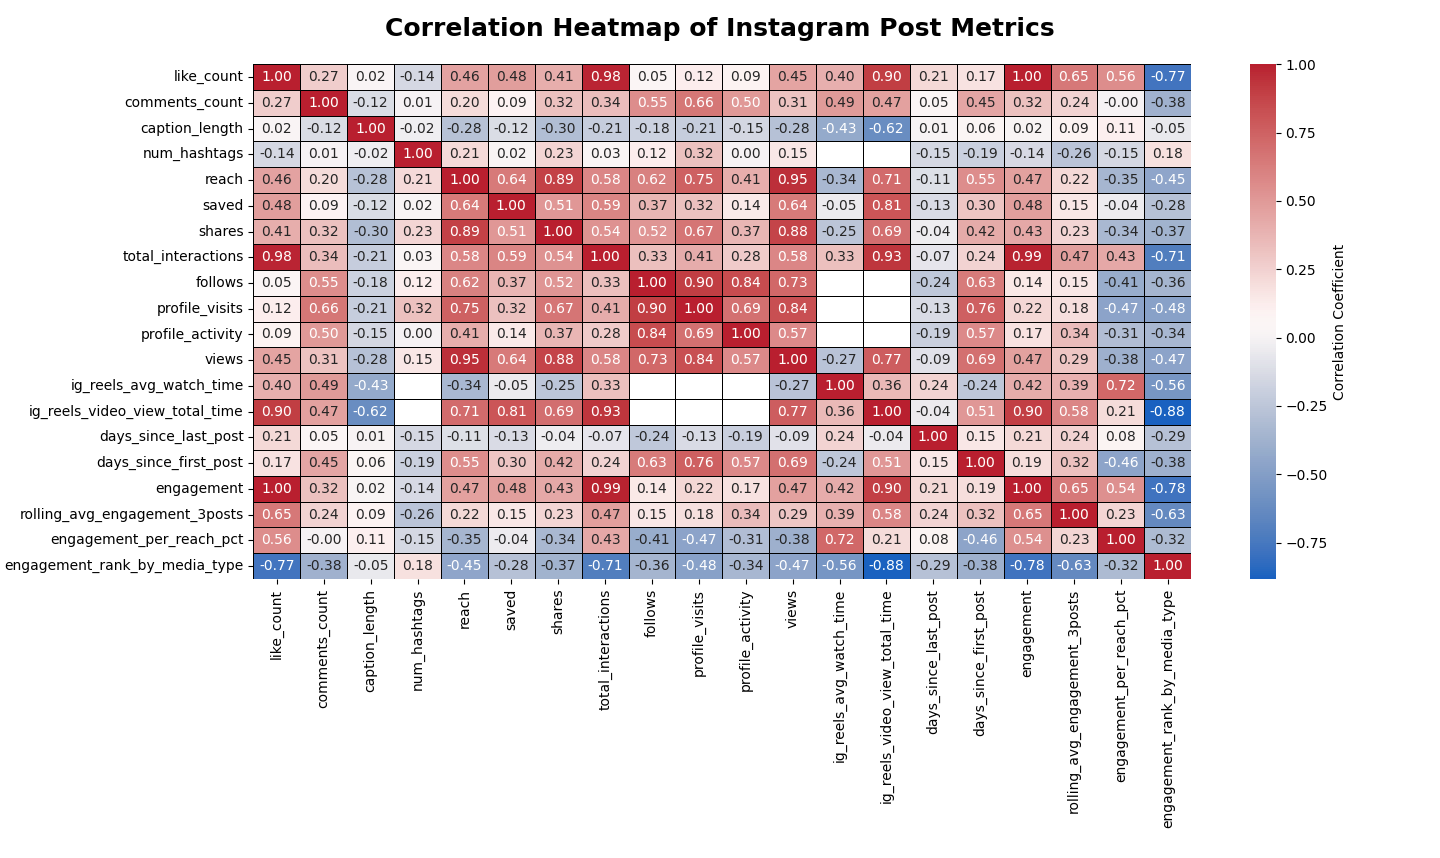

### Engagement & Reach Trends Over Time
> 
> This section examines Instagram post performance over time, focusing on `engagement`, `reach`, and `engagement` efficiency (`engagement_per_reach_pct`). We analyze trends, distributions, and correlations to uncover relationships between key metrics and posting patterns. A key question we aim to address is how `engagement` and `reach` move together—for instance, whether `engagement_per_reach_pct` remains stable as `reach` fluctuates over time.

In [ ]:
# Set up Seaborn styling and color palette
sns.set_style("whitegrid")
palette = sns.color_palette("muted")

# Initialize figure with two subplots
fig, ax = plt.subplots(2, 1, figsize = (15, 8))

# Pearson correlation and p-value between engagement and time
engagement_pearson_coeff, engagement_p_value = stats.pearsonr(x = ig_metrics_df['days_since_first_post'], y = ig_metrics_df['engagement'])

# Plot raw engagement over time 
ax[0].plot(ig_metrics_df['days_since_first_post'], ig_metrics_df['engagement'], color = palette[0])

# Rolling average engagement (smoother trendline)
ax[0].plot(ig_metrics_df['days_since_first_post'], ig_metrics_df['rolling_avg_engagement_3posts'], color = palette[1])

# Add legend
ax[0].legend(labels = ['engagement', 'rolling_avg_engagement_3posts'], fontsize = 8)

ax[0].fill_between(ig_metrics_df['days_since_first_post'], 0, ig_metrics_df['engagement'], alpha = .3)
ax[0].fill_between(ig_metrics_df['days_since_first_post'], 0, ig_metrics_df['rolling_avg_engagement_3posts'], alpha = .3)

ax[0].set_xlabel('Days Since First Post', fontsize = 12)
ax[0].set_ylabel('Engagement', fontsize = 12)
ax[0].set_title('Instagram Engagement Over Time', fontweight = 'bold', fontsize = 18)

# Pearson correlation annotation
ax[0].text(50, 80, f'Engagement & Days Since First Post:\npearson_coeff = {engagement_pearson_coeff}\np_value = {engagement_p_value}', fontweight = 'bold')

# Remove missing values before correlation
ig_reach = ig_metrics_df[ig_metrics_df['reach'].notnull()][['days_since_first_post', 'reach']]

# Pearson correlation and p-value between reach and time
reach_pearson_coeff, reach_p_value = stats.pearsonr(x = ig_reach['days_since_first_post'], y = ig_reach['reach'])

# Plot reach over time
ax[1].plot(ig_metrics_df['days_since_first_post'], ig_metrics_df['reach'], color = palette[3])
ax[1].fill_between(ig_metrics_df['days_since_first_post'], 0, ig_metrics_df['reach'], alpha = .3, color = palette[3])

ax[1].set_title('Instagram Reach Over Time', fontweight = 'bold', fontsize = 18)
ax[1].set_xlabel('Days Since First Post', fontsize = 12)
ax[1].set_ylabel('Reach (Unique Accounts)', fontsize = 12)

# Pearson correlation annotations
ax[1].text(780, 3300, f'Reach & Days Since First Post:\npearson_coeff = {reach_pearson_coeff}\np_value = {reach_p_value}', fontweight = 'bold')

# Vertical line showing when reach data begins
reach_days_min = ig_metrics_df[ig_metrics_df['reach'].notnull()].agg({'days_since_first_post': 'min'}).values[0]
ax[0].axvline(x = reach_days_min, color = palette[3], linestyle = '--')
ax[0].annotate('beginning of reach data', xy = (reach_days_min, 85), xytext = (reach_days_min + 50, 85), arrowprops = dict(facecolor = 'black', shrink = 0.05), fontweight = 'bold')

fig.tight_layout()
plt.savefig('engagement_reach_time.png')
plt.close()

>**Engagement & Reach Over Time:**
>
>- We visualize how raw `engagement`, rolling average engagement (`rolling_avg_engagement_3posts`), and `reach` change as the account ages. Pearson correlation coefficients quantify the relationship between `days_since_first_post` and each metric.
>
>- It appears that `engagement` **does not show any clear trend over time**, and the `rolling_avg_engagement_3posts` **fails to smooth the series** in a way that reveals actionable insights about changes in `engagement`.
>
>- In the **Instagram Engagement Over Time** plot, we annotate with a red line marking where `reach` data collection begins. This reflects the account’s transition to a "Creator" account, which provided access to advanced metrics. As a result, only the most recent 35 posts include recorded `reach` data.
>
>- While the `reach` **trendline is not strictly linear**, it does appear to be **gradually increasing over time**. This aligns with expectations: as follower count grows, the number of exposures per post should also rise.
>
>- `Engagement` **does not appear to consistently increase alongside** `reach` **over time**. While we might expect higher `reach` to drive higher `engagement`, the data does not clearly support this. In the next section, we take a closer look at the relationship between `reach` and `engagement_per_reach_pct` to gain a deeper understanding of how these metrics interact.

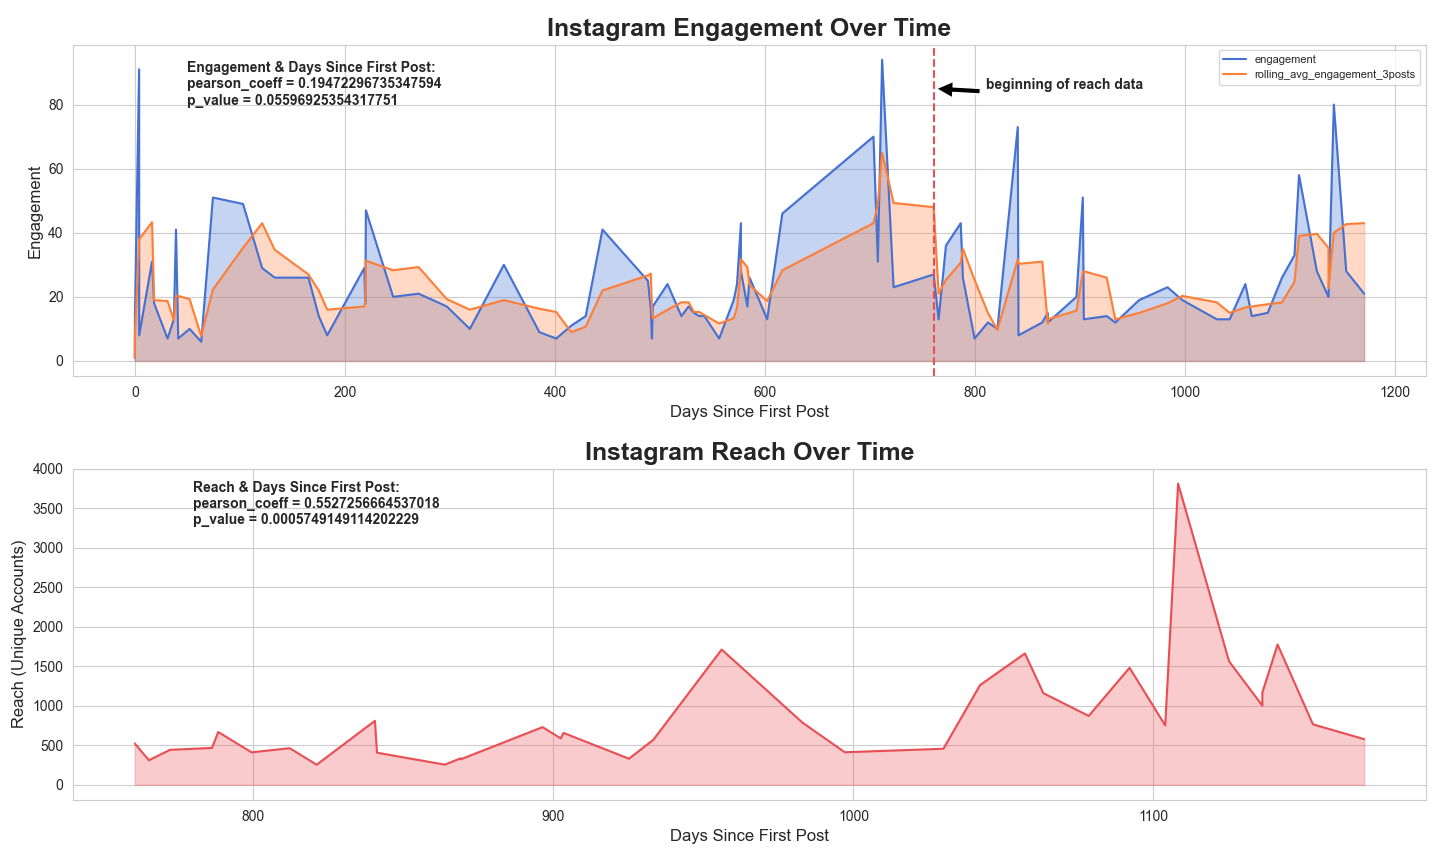

In [ ]:
# Initialize figure with two subplots
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

# Plot boxplot for engagement per reach (%)
sns.boxplot(data = ig_metrics_df, y = 'engagement_per_reach_pct', ax = ax[0], color = palette[0])
ax[0].set_title('Engagement per Reach (%) Distribution', fontsize = 18, fontweight = 'bold')
ax[0].set_ylabel('Engagement / Reach (%)', fontsize = 12)
ax[0].set_xlabel('')  # No x-axis label needed

# Plot boxplot for reach
sns.boxplot(data = ig_metrics_df, y = 'reach', ax = ax[1], color = palette[1])
ax[1].set_title('Reach Distribution', fontsize = 18, fontweight = 'bold')
ax[1].set_ylabel('Number of Accounts Reached', fontsize = 12)
ax[1].set_xlabel('')  # No x-axis label needed

plt.tight_layout()
plt.savefig('reach_engagement_rate_box.png')
plt.close()

> **Distribution of Engagement Rate & Reach:**
>
>- Next, we will plot `engagement_per_reach_pct` and `reach` over time (`days_since_first_post`) to better understand how `reach` impacts `engagement` efficiency.
>
>- Since these metrics are on very different scales, we first **need to standardize them**. Two common approaches are **StandardScaler** and **RobustScaler**, both available in `sklearn`. The choice depends on the shape of each feature’s distribution.
>
>- In our case, `engagement_per_reach_pct` is **slightly right-skewed**, while `reach` is **relatively symmetric** but includes a **strong outlier**. Because extreme values can distort scaling when using the mean, we opt for **RobustScaler**, which leverages the median and interquartile range (IQR) for a more robust transformation.

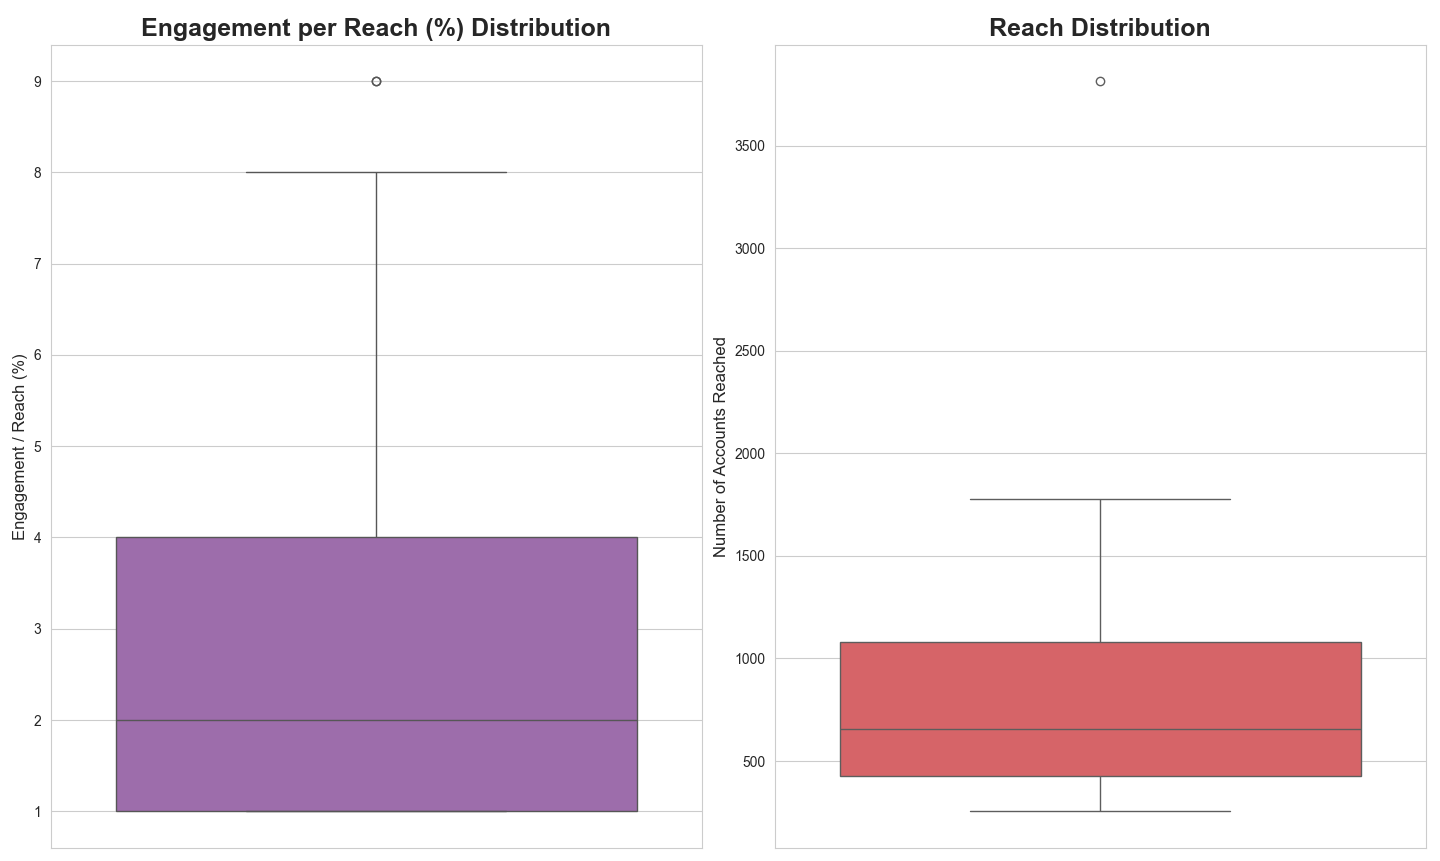

In [ ]:
# Initialize figure 
fig = plt.figure(figsize = (15, 8))

# Scale engagement_per_reach_pct and reach using RobustScaler to make them comparable
scaler = RobustScaler()
ig_metrics_df[['scaled_engagement_rate', 'scaled_reach']] = scaler.fit_transform(ig_metrics_df[['engagement_per_reach_pct', 'reach']])

# Plot scaled reach over time
plt.plot(ig_metrics_df['days_since_first_post'], ig_metrics_df['scaled_reach'], color = palette[3])

# Plot scaled engagement rate over time
plt.plot(ig_metrics_df['days_since_first_post'], ig_metrics_df['scaled_engagement_rate'], color = palette[4])

# Add legend
plt.legend(labels = ['scaled_reach', 'scaled_engagement_rate'], fontsize = 10)

plt.fill_between(ig_metrics_df['days_since_first_post'], 0, ig_metrics_df['scaled_reach'], alpha = .3, color = palette[3])
plt.fill_between(ig_metrics_df['days_since_first_post'], 0, ig_metrics_df['scaled_engagement_rate'], alpha = .3, color = palette[4])

plt.xlabel('Days Since First Post', fontsize = 12)
plt.ylabel('Scaled Metric Value', fontsize = 12)
plt.title('Comparison of Reach and Engagement per Reach Over Time', fontweight = 'bold', fontsize = 18)

# Select only rows where 'reach' is not null and keep relevant columns
ig_reach_engagement = ig_metrics_df[ig_metrics_df['reach'].notnull()][['engagement_per_reach_pct', 'reach']]

# Pearson correlation coefficient and p-value between reach and engagement per reach
reach_engagement_pearson_coeff, reach_engagement_p_value = stats.pearsonr(x = ig_reach_engagement['reach'], y = ig_reach_engagement['engagement_per_reach_pct'])

# Pearson correlation annotation
plt.text(780, 4, f'Reach & Engagement per Reach (%):\npearson_coeff = {reach_engagement_pearson_coeff}\np_value = {reach_engagement_p_value}', fontweight = 'bold')

plt.savefig('reach_eng_rate_trend.png')
plt.close()

# Drop the temporary scaled columns from the dataframe
ig_metrics_df.drop(columns = ['scaled_engagement_rate', 'scaled_reach'])

>**Comparing Reach & Engagement Efficiency Over Time:**
>
>The plot shows that as `reach` grows, `engagement_per_reach_pct` declines. The Pearson correlation coefficient confirms this trend (with a p-value < 0.05, indicating the **relationship is statistically significant**, rather than random). In other words, **broader exposure to posts does not necessarily translate into proportionally higher** `engagement`. The pattern—higher `engagement_per_reach_pct` when `reach` is low, followed by a decline as `reach` expands—could imply that **posts are either losing their overall engaging quality over time**, or that **new audiences being reached are less responsive than the original core audience**, which remains consistently engaged.

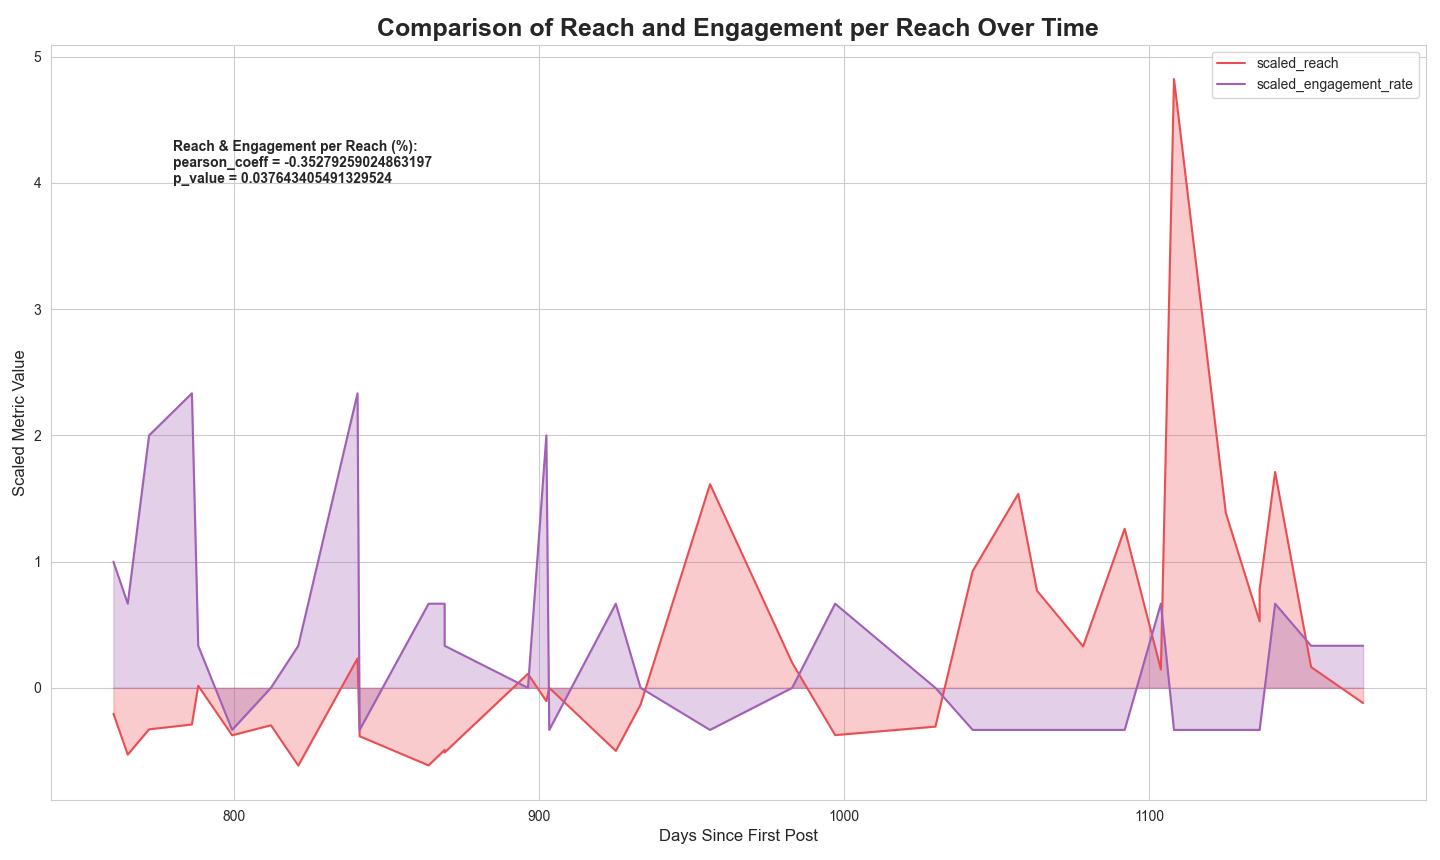

### Feature Relationships with Reach & Engagement
>To better understand performance patterns, we examine how **reach** and **engagement** vary with different features such as:  
>- `media_type`
>- `time_of_day`
>- `day_of_week`
>
>By plotting these relationships, we can identify whether certain posting strategies are associated with higher exposure and interaction.  For example, **some features may show a positive relationship** with `reach` or `engagement` (e.g., certain media types consistently gain broader visibility or generate more likes/comments).  
>
>These insights may help us evaluate not just overall performance, but also the **drivers** behind changes in `reach` and `engagement`.

In [ ]:
def get_reach_engagement(dataframe, feature, xlabel, ax10_title, ax11_title):
	# Count how many posts fall into each category of the chosen feature
	# NOTE: engagement is recorded for all ~100 posts, but reach is only available for 35 posts.
	# To make fair comparisons, we generate separate count distributions for engagement and reach.
	eng_feature_counts = dataframe.groupby(feature, as_index = False).agg({'post_id': 'count'}).rename(columns = {'post_id': 'count'})
	reach_feature_counts = dataframe[dataframe['reach'].notnull()].groupby(feature, as_index = False).agg({'post_id': 'count'}).rename(columns = {'post_id': 'count'})

	# Alphabetically order feature labels (helps align plots consistently)
	eng_ordered_features = sorted(eng_feature_counts[feature].unique())
	reach_ordered_features = sorted(reach_feature_counts[feature].unique())

	# Initialize figure 
	fig, ax = plt.subplots(2, 2, figsize = (15, 8))

	# Set up Seaborn color palettes to be used in the following plots
	palette0 = sns.color_palette("deep")
	palette1 = sns.color_palette("viridis")

	# Bar chart of post counts by feature (Engagement dataset, ~100 posts)
	ax[0, 0].bar(eng_feature_counts[feature], eng_feature_counts['count'], color = palette0)
	ax[0, 0].set_xlabel(xlabel, fontsize = 12)  # e.g., "Media Type" or "Day of Week"
	ax[0, 0].set_ylabel('Number of Posts (All Engagement Data)', fontsize = 12)
	ax[0, 0].set_title('Post Counts by ' + xlabel + ' (Engagement Dataset)', fontsize = 18, fontweight = 'bold')

	# Boxplot of engagement by feature 
	sns.boxplot(data = dataframe, x = feature, y = 'engagement', palette = palette0, ax = ax[1, 0], order = eng_ordered_features)
	ax[1, 0].set_xlabel(xlabel, fontsize = 12)
	ax[1, 0].set_ylabel('Engagement (Likes + Comments)', fontsize = 12)
	ax[1, 0].set_title(ax10_title, fontsize = 18, fontweight = 'bold')

	# Bar chart of post counts by feature (Reach dataset, 35 posts)
	ax[0, 1].bar(reach_feature_counts[feature], reach_feature_counts['count'], color = palette1)
	ax[0, 1].set_xlabel(xlabel, fontsize = 12)  # e.g., "Media Type" or "Day of Week"
	ax[0, 1].set_ylabel('Number of Posts (Reach Subset)', fontsize = 12)
	ax[0, 1].set_title('Post Counts by ' + xlabel + ' (Reach Dataset)', fontsize = 18, fontweight = 'bold')

	# Boxplot of reach by feature 
	sns.boxplot(data = dataframe, x = feature, y = 'reach', palette = palette1, ax = ax[1, 1], order = reach_ordered_features)
	ax[1, 1].set_xlabel(xlabel, fontsize = 12)
	ax[1, 1].set_ylabel('Reach (Unique Accounts)', fontsize = 12)
	ax[1, 1].set_title(ax11_title, fontsize = 18, fontweight = 'bold')

	# Adjust layout to prevent overlap
	fig.tight_layout()

    plt.savefig(f'{feature}_plots.png')
	plt.close()

In [ ]:
get_reach_engagement(ig_metrics_df, 'media_type', 'Media Type', 'Engagement Distribution By Media Type', 'Reach Distribution By Media Type')

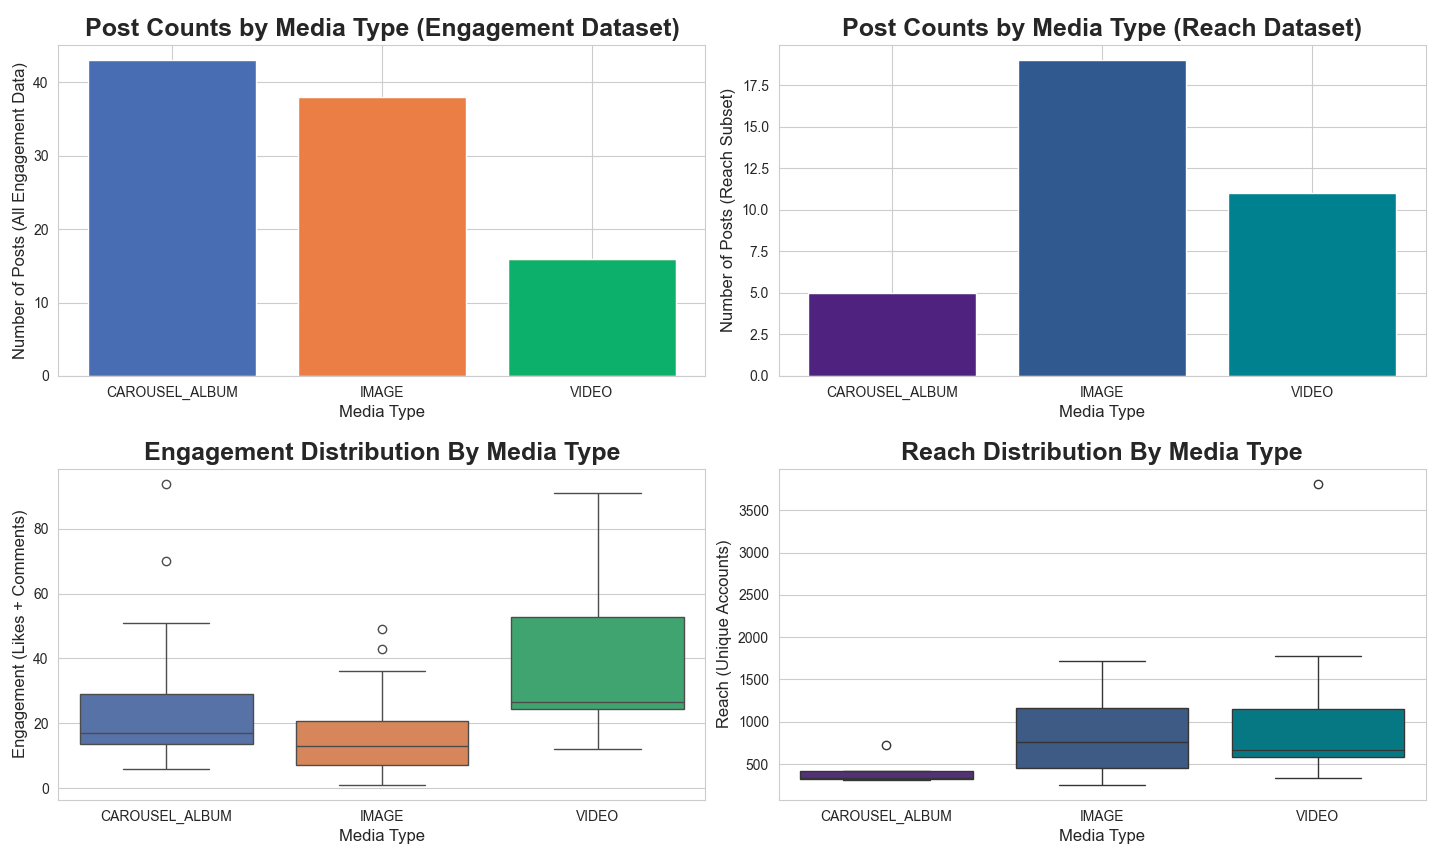

In [ ]:
get_reach_engagement(ig_metrics_df, 'time_of_day', 'Time of Day', 'Engagement Distribution By Time of Day', 'Reach Distribution By Time of Day')

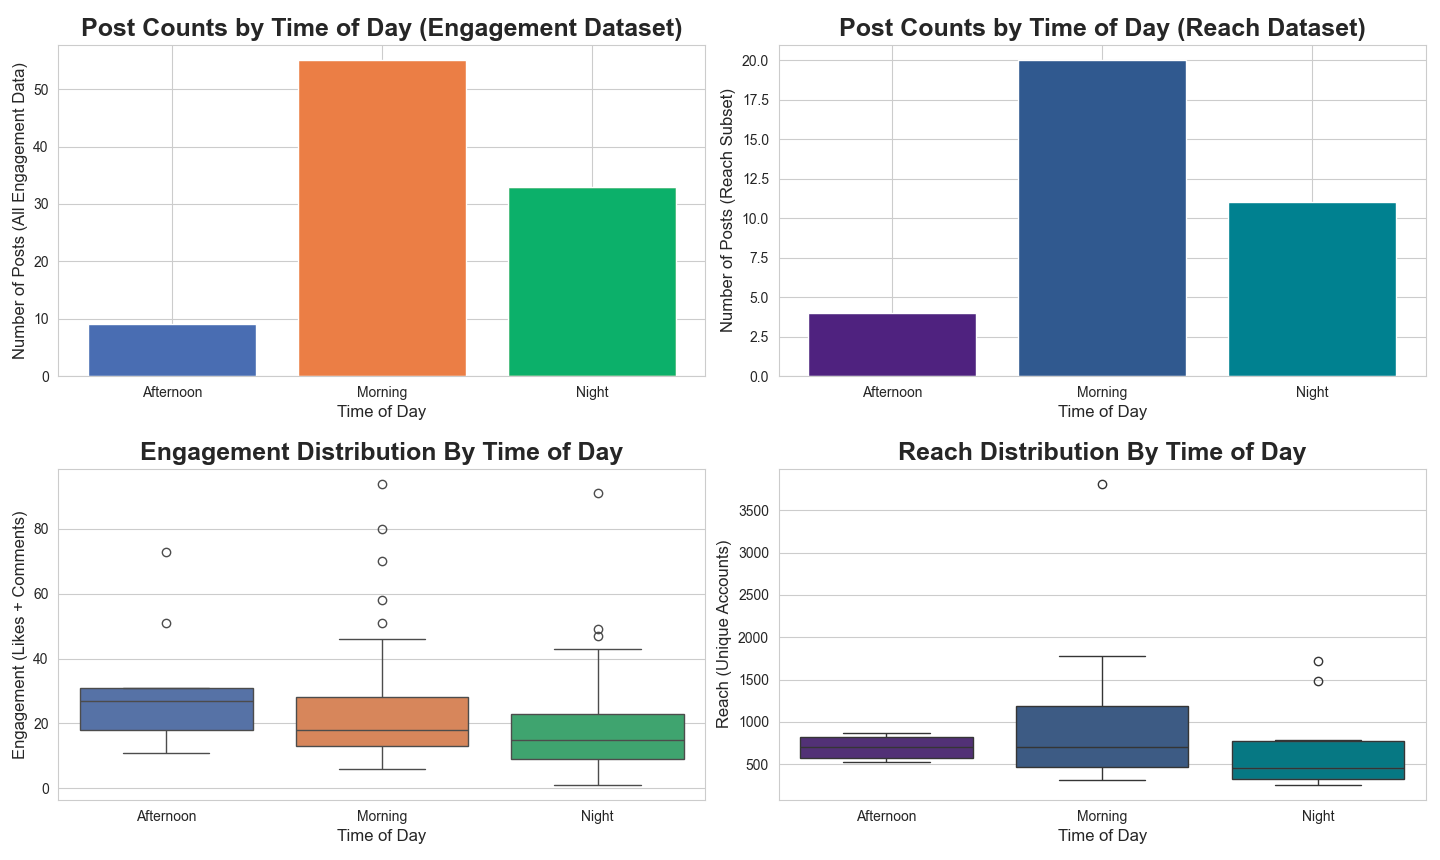

In [ ]:
get_reach_engagement(ig_metrics_df, 'day_of_week', 'Day of Week', 'Engagement Distribution By Day of Week', 'Reach Distribution By Day of Week')

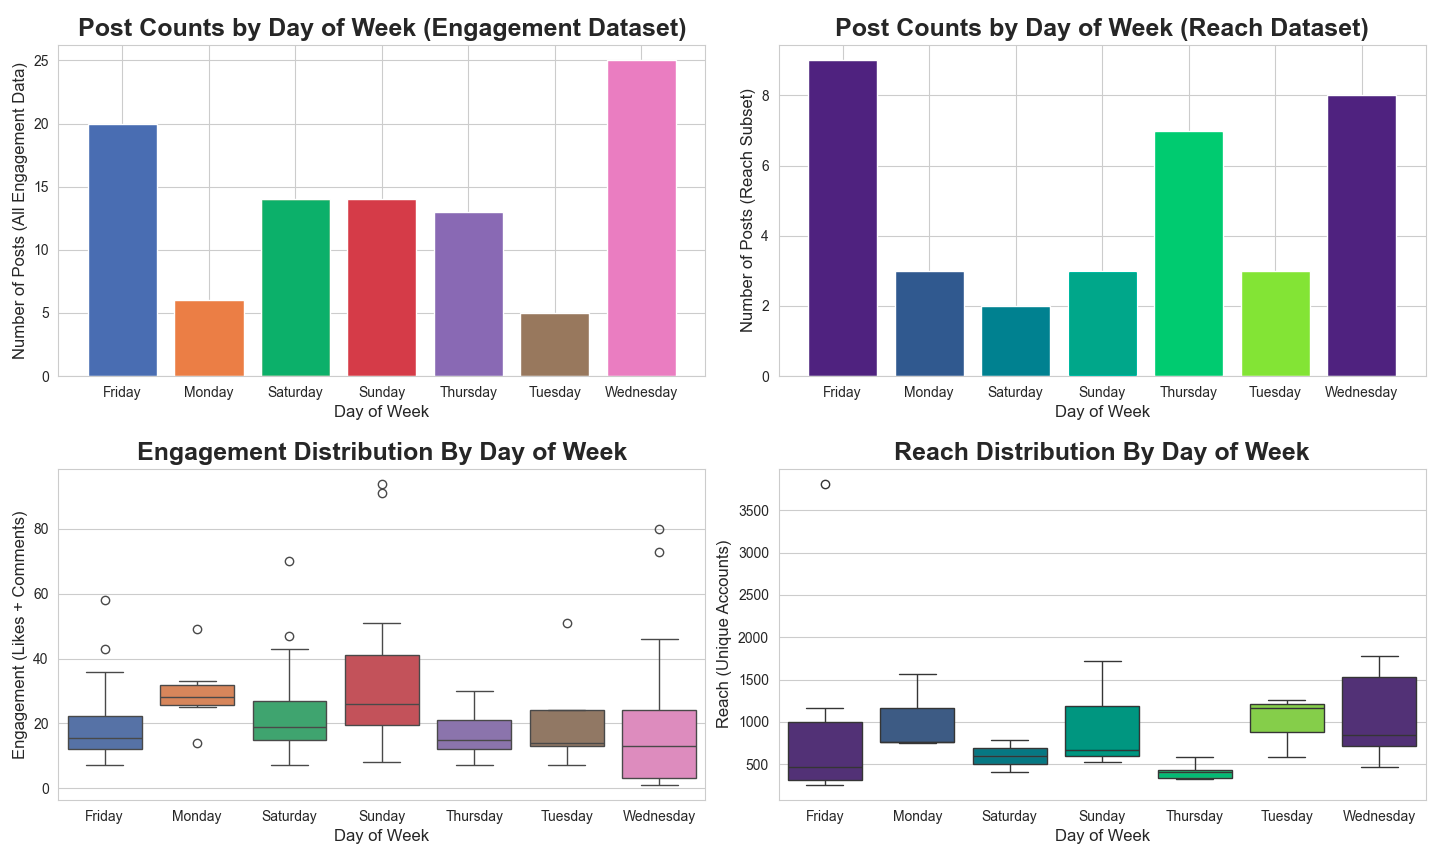

In [12]:
ig_metrics_df.to_csv('ig_post_metrics.csv', index = False)
engagement_all_posts.to_csv('engagement_all_posts.csv', index = False)
creator_posts.to_csv('creator_posts.csv', index = False)